In [1]:

import numpy as np
import os
os.environ["CUDA_HOME"]="/usr/local/cuda-11.1/"
os.environ["PATH"] = f"{os.environ['CUDA_HOME']}/bin:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CUDA_HOME']}/lib64:" + os.environ["LD_LIBRARY_PATH"]
from lib.datasets.kitti.kitti_dataset import KITTI_Dataset
# import plot
import matplotlib.pyplot as plt
import torch
# torch.cuda.set_device("cuda:3")

cfg = {'root_dir': '/server19/mushiyi/smb9_msy/03-Data/02-KITTI/object/training',
  # root_dir: '/server24/mushiyi/03-KITTI-ori/object/'
  'train_txt': '/server19/mushiyi/smb9_msy/03-Data/02-KITTI/object/training/ImageSets/train.txt',
  'root_dir_eval': '/server19/mushiyi/smb9_msy/03-Data/02-KITTI/object/training',
  "get_img_right": True,
  "get_disparity": True,
  "get_disparity_on_the_fly": True,
  "resolution_ori": [1280, 388], # [1280, 388],
  "resolution_ori_check_filter": False,
  "batch_size": 1,
  "use_3d_center": True,
  "class_merging": False,
  "use_dontcare": False,
  "get_depth_sample_points": True,
  "bbox2d_type": 'anno',  # 'proj' or 'anno'
  "meanshape": False,  # use predefined anchor or not
  # writelist_train: ['Car', 'Pedestrian', 'Cyclist']
  "writelist_train": ['Car', 'Pedestrian', 'Cyclist'],
  "writelist_Eval": ['Car', 'Pedestrian', 'Cyclist'],
  "crop_top": 100,
  "clip_2d": False,
  "ingore_3dcenter_out_of_img": True,
  "ingore_far_object": True,
  "drop_unkown_level": True,

  "aug_pd": False,
  "aug_crop": False,
  "random_mixup3d": 0,

  "random_flip": 0,
  "random_switch": 0.0,
  "random_crop": 0,
  "scale": 0,
  "shift": 0,

  "depth_scale": 'normal',
  "decouple": False,
  "stereo_shift_aug": 0,
}

dataset_train = KITTI_Dataset('train', cfg)




/data/msy/conda_env/monodetr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>>mushiyi>>> self.matcher_mode>>>>>  StereoBM
self.split train


In [2]:
index = dataset_train.idx_list[1]
objects = dataset_train.get_label(index)
for object in objects:
    print(object.to_kitti_format())
img = dataset_train.get_image(index)

img3 = dataset_train.get_image3(index)

Car 0.00 0 1.55 614.24 181.78 727.31 284.77 1.57 1.73 4.15 1.00 1.75 13.22 1.62
DontCare -1.00 -1 -10.00 5.00 229.89 214.12 367.61 -1.00 -1.00 -1.00 -1000.00 -1000.00 -1000.00 -10.00
DontCare -1.00 -1 -10.00 522.25 202.35 547.77 219.71 -1.00 -1.00 -1.00 -1000.00 -1000.00 -1000.00 -10.00


In [29]:
import cv2
import numpy as np
import skimage.measure

def get_disparty_P2_onfly(img_left, img_right, matcher_mode="StereoBM", 
                          flip_flag=False, switch_flag=False, noise_levels=None):
    """
    计算视差图，并统计有效像素率与噪声敏感性

    Args:
        img_left, img_right: 左右图像 (PIL 或 numpy)
        matcher_mode: "StereoBM" | "SGBM" | "WLS"
        flip_flag, switch_flag: 翻转控制
        noise_levels: list[int]，如 [1, 2, 5] 表示要测试的噪声范围

    Returns:
        disparity_left: np.ndarray, 视差图
        valid_pixel_rate: float, 有效像素率 (非零像素比例)
        noise_sensitivity: dict, 噪声敏感性（噪声幅度→变化率）
    """
    # 转灰度
    left_image = cv2.cvtColor(np.asarray(img_left), cv2.COLOR_RGB2BGR)
    right_image = cv2.cvtColor(np.asarray(img_right), cv2.COLOR_RGB2BGR)
    gray1 = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    # ========== (0) 预处理翻转 ==========
    if flip_flag or switch_flag:
        gray1 = cv2.flip(gray1, 1)
        gray2 = cv2.flip(gray2, 1)

    # ========== (1) 匹配器选择 ==========
    if matcher_mode == "StereoBM":
        matcher = cv2.StereoBM_create(numDisparities=192, blockSize=25)
        disparity = matcher.compute(gray1, gray2)
    elif matcher_mode == "SGBM":
        matcher = cv2.StereoSGBM_create(
            numDisparities=192, blockSize=5, 
            P1=8 * 3 * 5 ** 2, P2=32 * 3 * 5 ** 2
        )
        disparity = matcher.compute(gray1, gray2)
    elif matcher_mode == "WLS":
        # 左右匹配器
        left_matcher = cv2.StereoSGBM_create(
            numDisparities=192, blockSize=5, 
            P1=8 * 3 * 5 ** 2, P2=32 * 3 * 5 ** 2
        )
        right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

        # 计算左右视差
        displ = left_matcher.compute(gray1, gray2)
        dispr = right_matcher.compute(gray2, gray1)

        # 创建并应用 WLS 滤波器
        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
        wls_filter.setLambda(8000.0)   # 平滑度系数（越大越平滑）
        wls_filter.setSigmaColor(1.5)  # 颜色敏感度
        disparity = wls_filter.filter(displ, gray1, disparity_map_right=dispr)
    else:
        raise ValueError(f"Unknown matcher_mode: {matcher_mode}")

    # ========== (2) 视差归一化 ==========
    disparity = disparity.astype(np.float32) / 16.0
    disparity[disparity < 0] = 0
    disparity = skimage.measure.block_reduce(disparity, (4, 4), np.max)

    # ========== (3) 有效像素率 ==========
    valid_pixel_rate = np.count_nonzero(disparity) / disparity.size

    # ========== (4) 噪声敏感性 ==========
    noise_sensitivity = {}
    if noise_levels is not None:
        for nl in noise_levels:
            noise = np.random.uniform(-nl, nl, disparity.shape)
            noisy_disp = disparity + noise
            noisy_disp[noisy_disp < 0] = 0

            diff = np.abs(noisy_disp - disparity)
            noise_sensitivity[nl] = np.mean(diff)

    return disparity, valid_pixel_rate, noise_sensitivity

# ====== 示例使用 ======
disparity, valid_rate, sensitivity = get_disparty_P2_onfly(
    img_left=img, img_right=img3, matcher_mode="SGBM",
    flip_flag=False, switch_flag=False,
    noise_levels=[1, 2, 5]
)

print(f"✅ Valid pixel rate: {valid_rate * 100:.2f}%")
print(f"✅ Noise sensitivity (mean diff): {sensitivity}")


✅ Valid pixel rate: 84.57%
✅ Noise sensitivity (mean diff): {1: 0.46076980757629515, 2: 0.9288994216562585, 5: 2.2999519698539133}


Computing disparity statistics:   0%|          | 0/10 [00:00<?, ?it/s]

✅ [StereoBM] Valid pixel rate: 41.86%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.35336726321109924, 2: 0.706109509451321, 5: 1.7626768815009108}
✅ [SGBM] Valid pixel rate: 82.51%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.4527449150148581, 2: 0.9109453359044432, 5: 2.283235941729016}


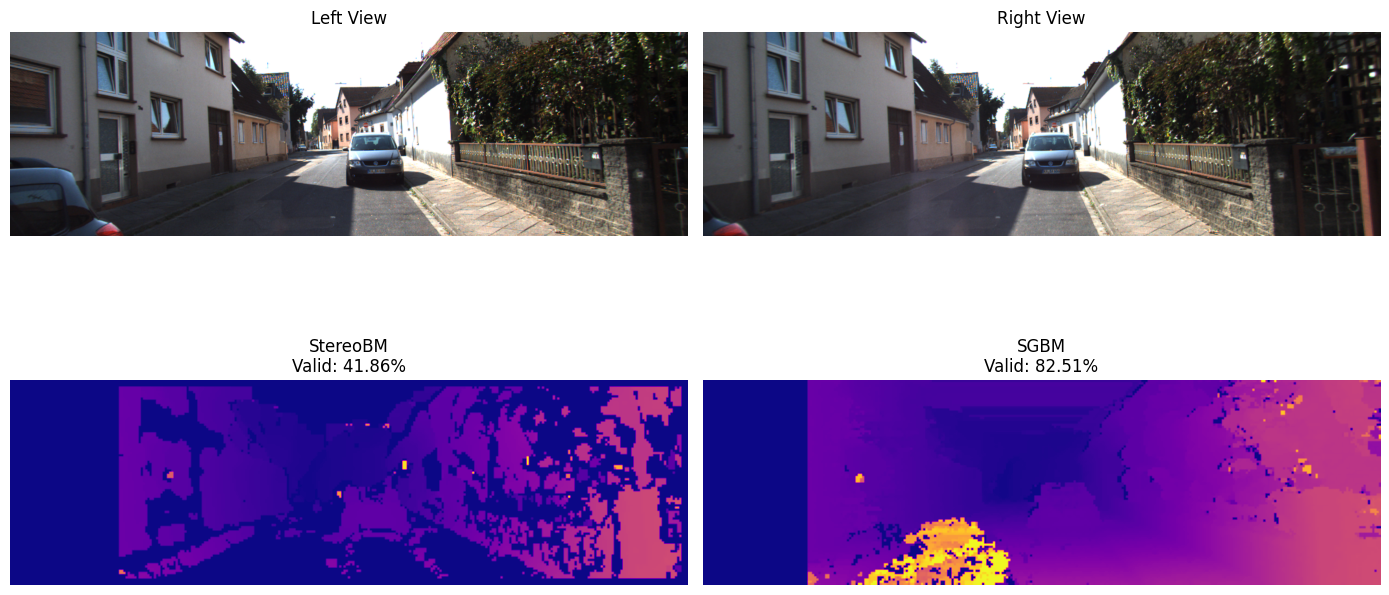

Computing disparity statistics:  10%|█         | 1/10 [00:00<00:08,  1.09it/s]

✅ [StereoBM] Valid pixel rate: 44.57%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.3602971160443492, 2: 0.7346715149458629, 5: 1.8017258449246047}
✅ [SGBM] Valid pixel rate: 83.15%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.45888833482104907, 2: 0.9168636273191315, 5: 2.2729490589560712}


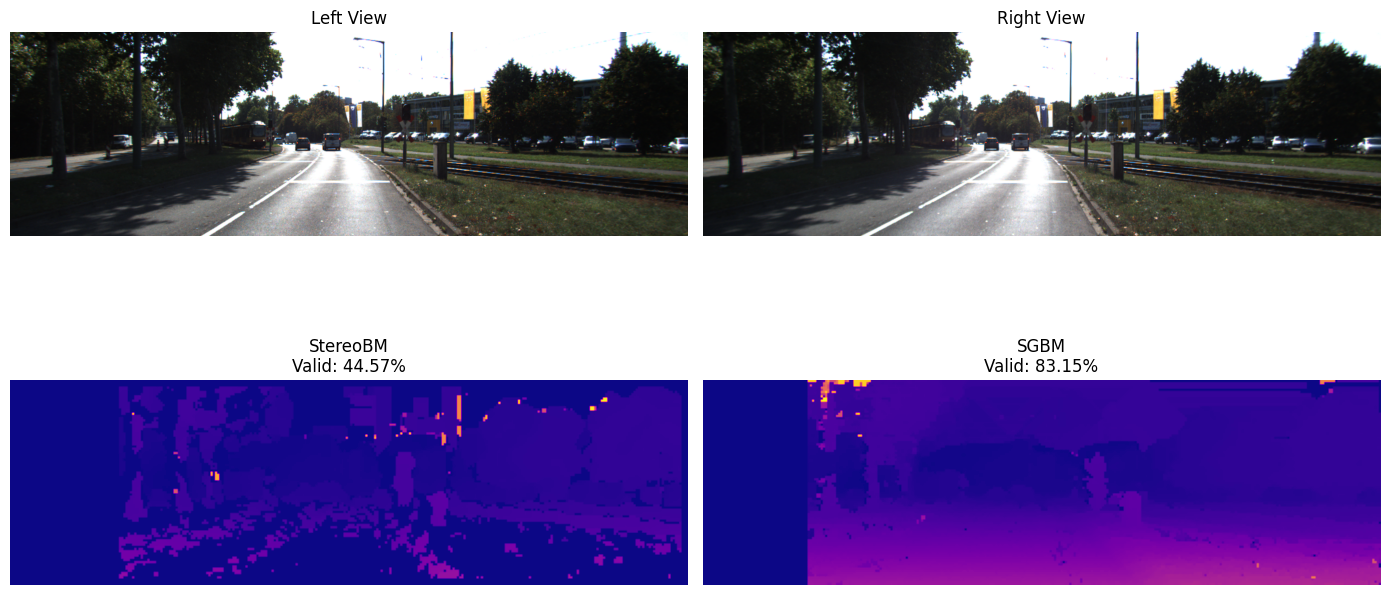

Computing disparity statistics:  20%|██        | 2/10 [00:01<00:07,  1.10it/s]

✅ [StereoBM] Valid pixel rate: 48.80%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.37339468751082194, 2: 0.7415923533083651, 5: 1.8593502635658599}
✅ [SGBM] Valid pixel rate: 84.04%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.45879950155529053, 2: 0.9187105477230287, 5: 2.3030950139829094}


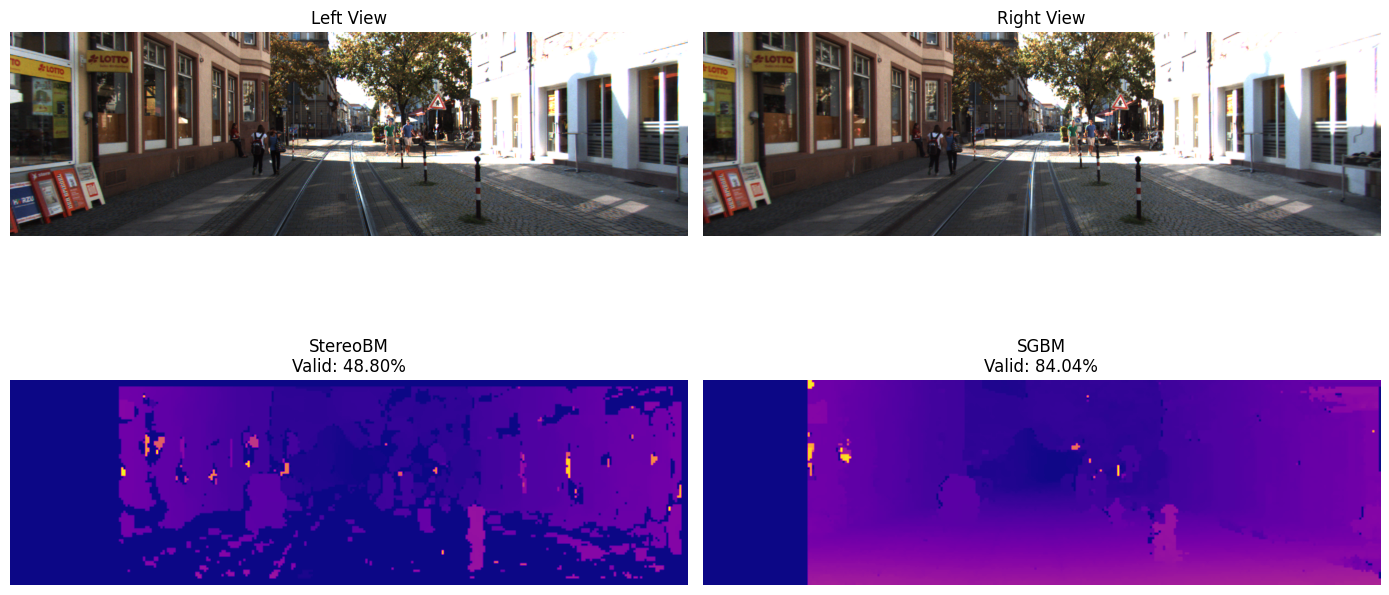

Computing disparity statistics:  30%|███       | 3/10 [00:02<00:06,  1.11it/s]

✅ [StereoBM] Valid pixel rate: 37.99%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.34757956571936266, 2: 0.690263296546809, 5: 1.711444186025515}
✅ [SGBM] Valid pixel rate: 83.97%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.4564742472754458, 2: 0.9220996899941803, 5: 2.272439797987914}


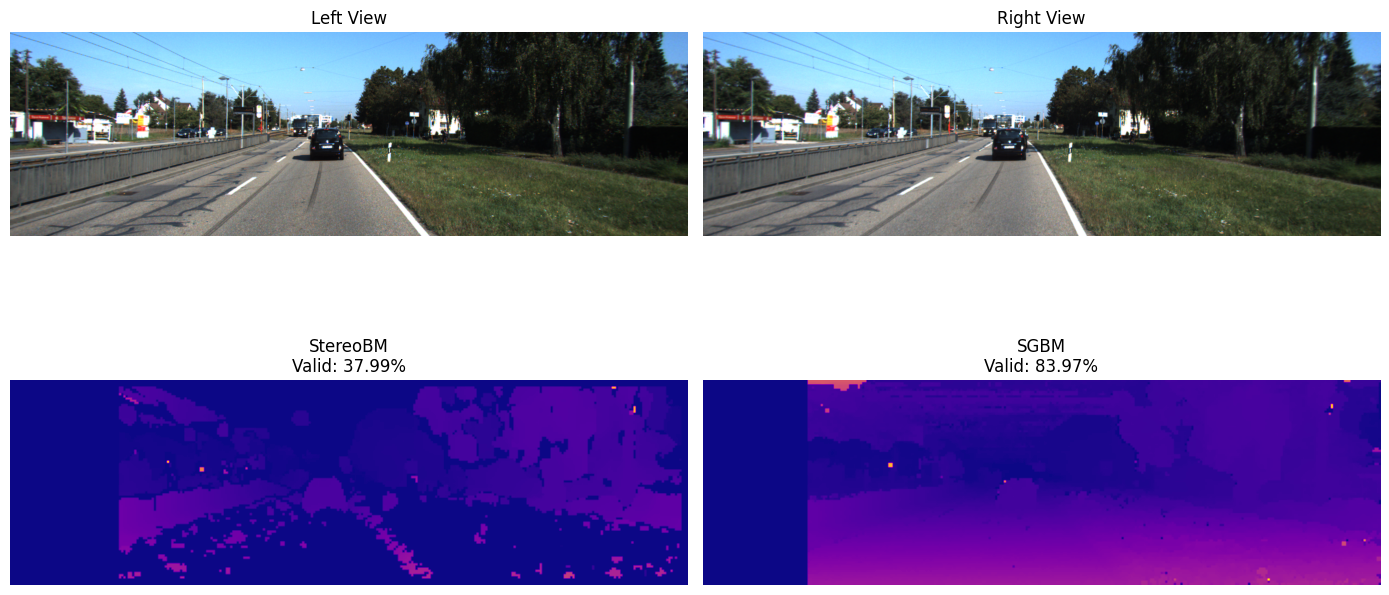

Computing disparity statistics:  40%|████      | 4/10 [00:03<00:05,  1.12it/s]

✅ [StereoBM] Valid pixel rate: 46.51%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.37248939843445716, 2: 0.7307500569254058, 5: 1.8401167519081172}
✅ [SGBM] Valid pixel rate: 83.02%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.45580854968801354, 2: 0.913653096806453, 5: 2.276364706834483}


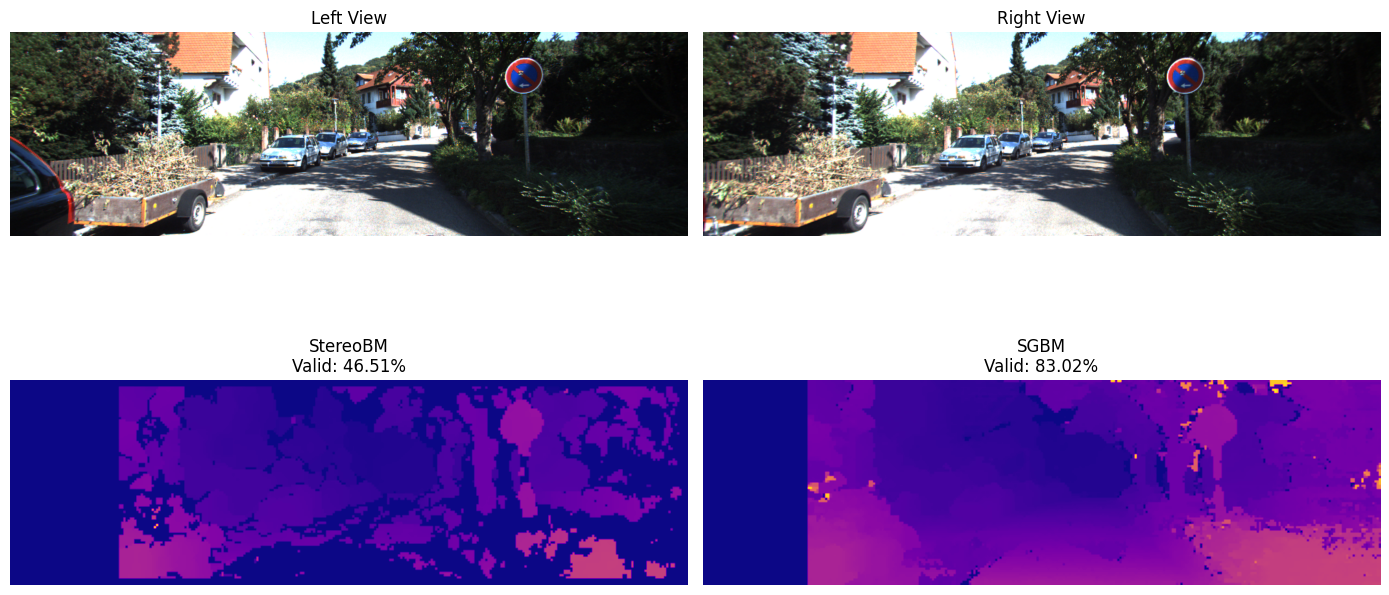

Computing disparity statistics:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

✅ [StereoBM] Valid pixel rate: 42.15%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.3544913871858049, 2: 0.7095434106838033, 5: 1.7338343847520625}
✅ [SGBM] Valid pixel rate: 83.00%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.45589101674206906, 2: 0.9092809626646708, 5: 2.275568100299742}


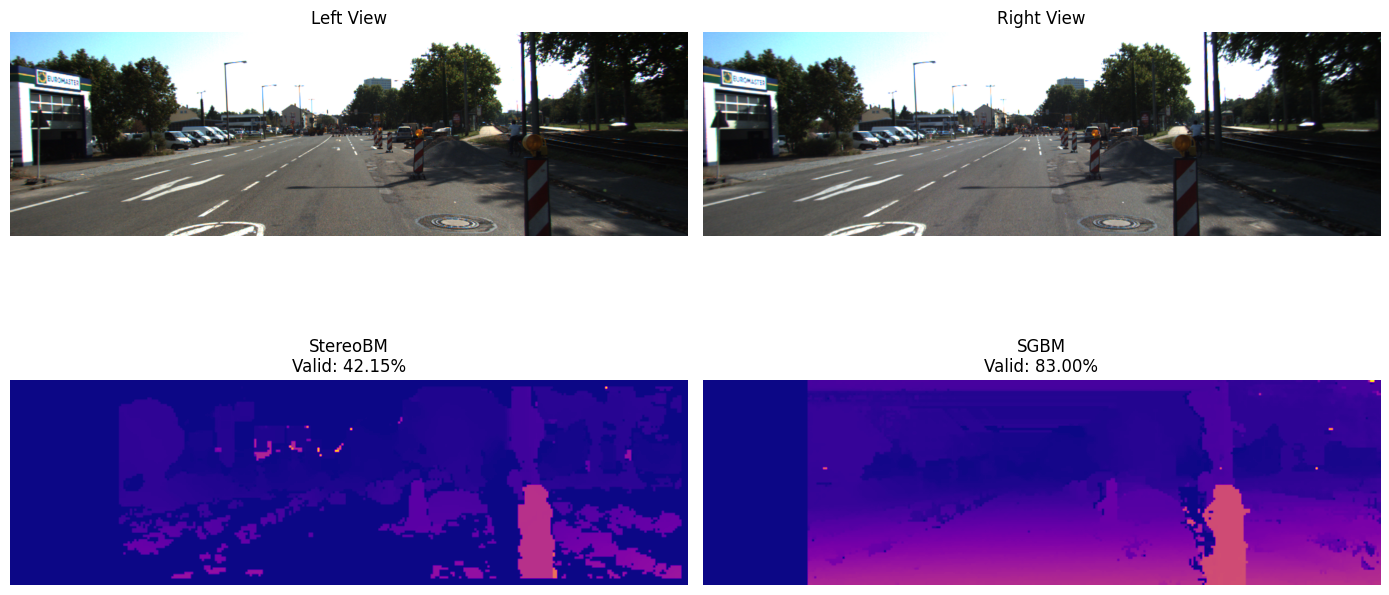

Computing disparity statistics:  60%|██████    | 6/10 [00:05<00:03,  1.09it/s]

✅ [StereoBM] Valid pixel rate: 54.00%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.3885102017099038, 2: 0.7749158864205712, 5: 1.933322524486101}
✅ [SGBM] Valid pixel rate: 83.23%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.46287528827895996, 2: 0.9142550986526788, 5: 2.2751774248033754}


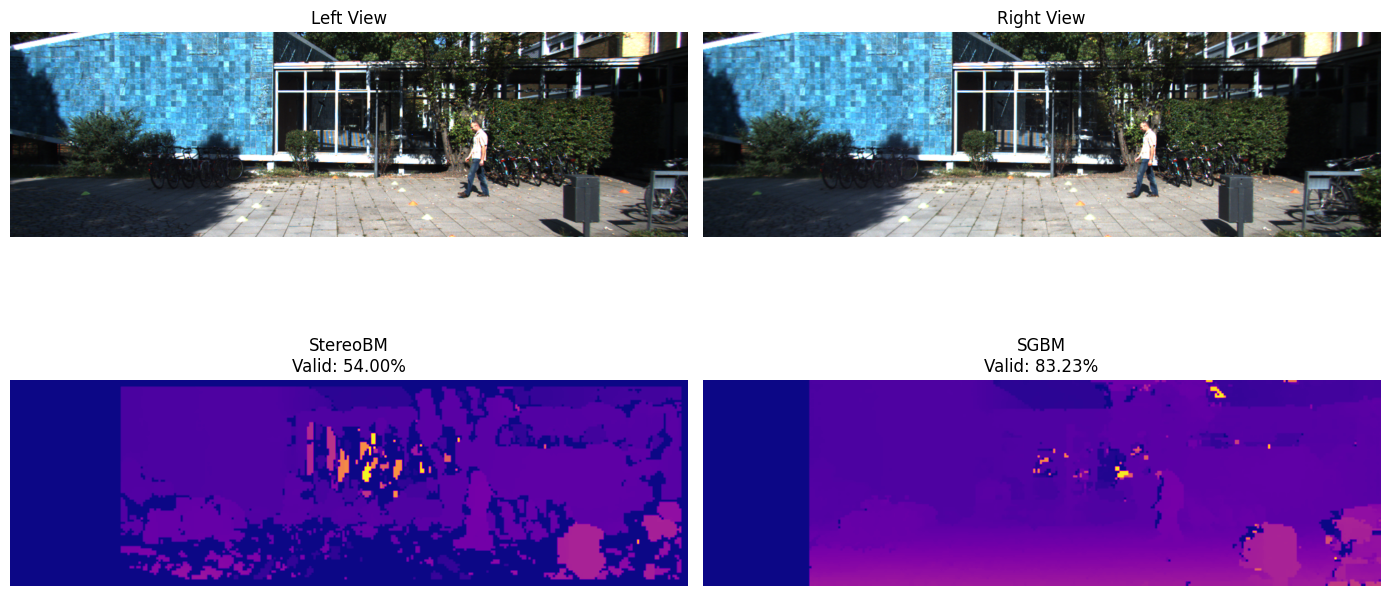

Computing disparity statistics:  70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

✅ [StereoBM] Valid pixel rate: 44.83%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.36219061213808634, 2: 0.7298058250424057, 5: 1.8000665399771236}
✅ [SGBM] Valid pixel rate: 83.99%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.457871356663163, 2: 0.9213178736158177, 5: 2.286422929356735}


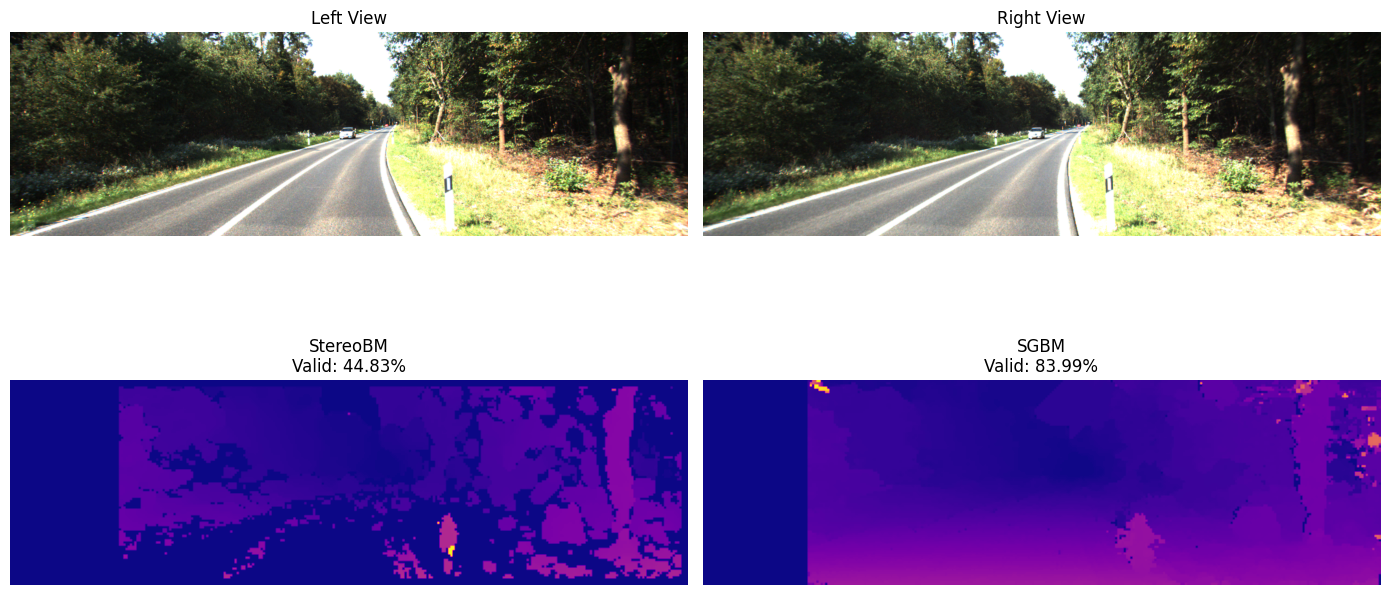

Computing disparity statistics:  80%|████████  | 8/10 [00:07<00:01,  1.05it/s]

✅ [StereoBM] Valid pixel rate: 48.77%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.3720608514941664, 2: 0.7443049806092468, 5: 1.8458669240720007}
✅ [SGBM] Valid pixel rate: 83.80%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.4586555934356398, 2: 0.9200555988517998, 5: 2.292920306420867}


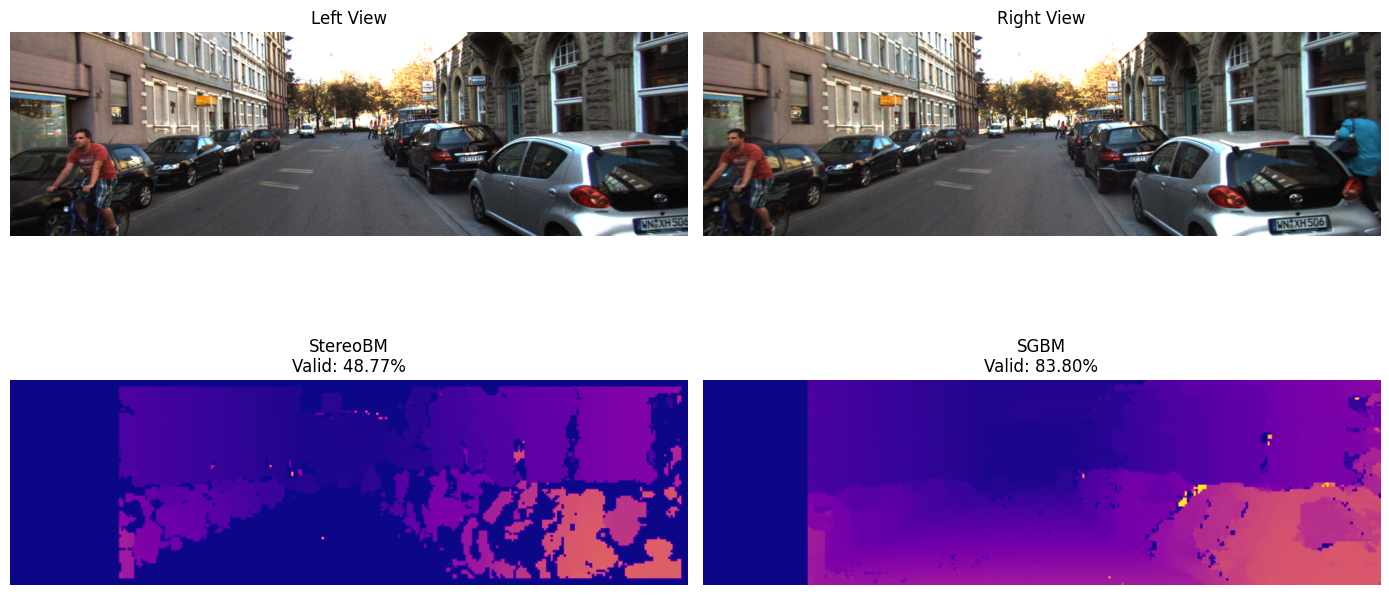

Computing disparity statistics:  90%|█████████ | 9/10 [00:08<00:00,  1.08it/s]

✅ [StereoBM] Valid pixel rate: 35.56%
✅ [StereoBM] Noise sensitivity (mean diff): {1: 0.3421926261705616, 2: 0.6716360247159551, 5: 1.6824269677124781}
✅ [SGBM] Valid pixel rate: 83.65%
✅ [SGBM] Noise sensitivity (mean diff): {1: 0.4598626294480633, 2: 0.9198510522227147, 5: 2.282758008419774}


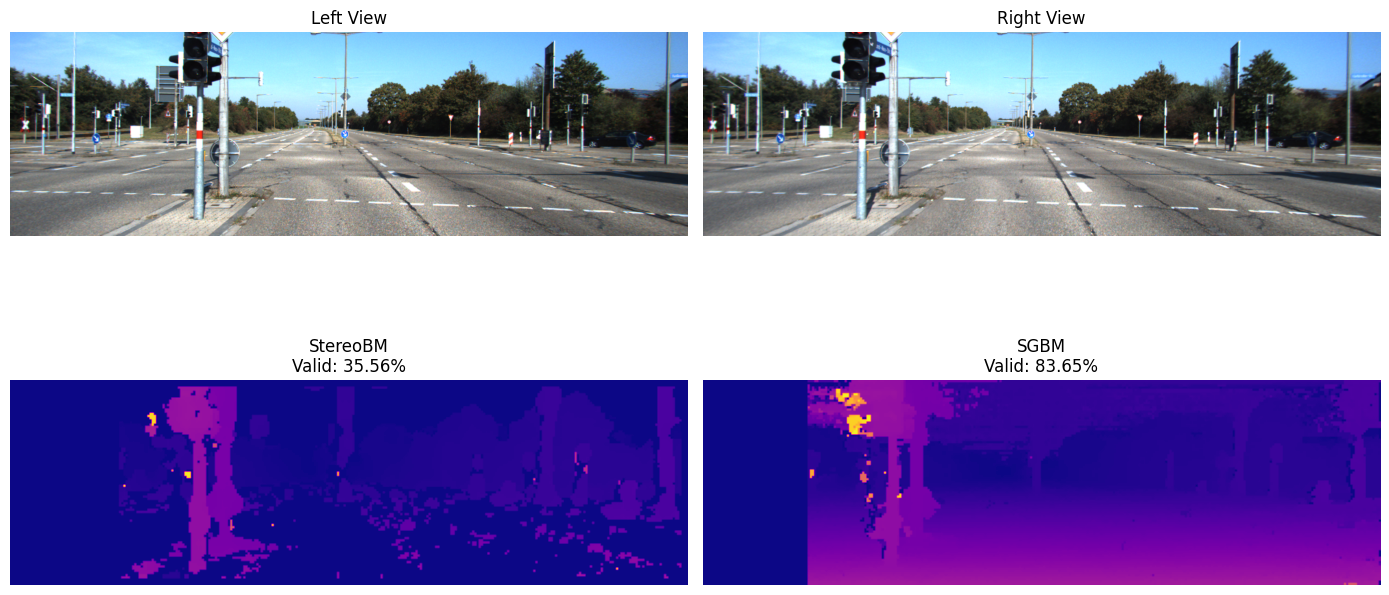

Computing disparity statistics: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ====== 视差模式 ======
modes = ["StereoBM", "SGBM"]
for index in tqdm(dataset_train.idx_list[1:100:10], desc="Computing disparity statistics"):
    img = dataset_train.get_image(index)

    img3 = dataset_train.get_image3(index)
    # ====== 确保输入图像为 numpy array ======
    if not isinstance(img, np.ndarray):
        img_np = np.array(img)
    else:
        img_np = img

    if not isinstance(img3, np.ndarray):
        img3_np = np.array(img3)
    else:
        img3_np = img3

    # ====== 获取视差图并计算有效像素率和噪声敏感性 ======
    for mode in modes:
        disparity, valid_rate, sensitivity = get_disparty_P2_onfly(
            img_left=img_np, img_right=img3_np,
            matcher_mode=mode,
            flip_flag=False, switch_flag=False,
            noise_levels=[1, 2, 5]
        )
        results[mode] = (disparity, valid_rate, sensitivity)
        print(f"✅ [{mode}] Valid pixel rate: {valid_rate * 100:.2f}%")
        print(f"✅ [{mode}] Noise sensitivity (mean diff): {sensitivity}")

    # ====== 可视化 ======
    plt.figure(figsize=(14, 8))

    # --- 上排：左右视图 ---
    plt.subplot(2, len(modes), 1)
    plt.imshow(img_np)
    plt.title("Left View")
    plt.axis('off')

    plt.subplot(2, len(modes), 2)
    plt.imshow(img3_np)
    plt.title("Right View")
    plt.axis('off')

    # --- 下排：各匹配器视差图 ---
    for i, mode in enumerate(modes):
        disp_vis = results[mode][0]
        disp_vis = cv2.normalize(disp_vis, None, 0, 255, cv2.NORM_MINMAX)
        disp_vis = disp_vis.astype('uint8')
        plt.subplot(2, len(modes), len(modes) + i + 1)
        plt.imshow(disp_vis, cmap='plasma')
        plt.title(f"{mode}\nValid: {results[mode][1]*100:.2f}%")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [42]:
import numpy as np
import csv
from tqdm import tqdm

results = []

for index in tqdm(dataset_train.idx_list, desc="Computing disparity statistics"):
    # 1️⃣ 获取左右图像
    img_left = dataset_train.get_image(index)
    img_right = dataset_train.get_image3(index)
    
    # 2️⃣ 计算视差 + 有效像素率 + 噪声敏感性
    disparity, valid_rate, sensitivity = get_disparty_P2_onfly(
        img_left=img_left,
        img_right=img_right,
        flip_flag=False,
        switch_flag=False,
        matcher_mode="StereoBM",
        noise_levels=[1, 2, 5]
    )
    
    # 3️⃣ 记录结果
    results.append({
        "index": index,
        "valid_pixel_rate": valid_rate,
        "noise_1px": sensitivity.get(1, np.nan),
        "noise_2px": sensitivity.get(2, np.nan),
        "noise_5px": sensitivity.get(5, np.nan)
    })

# 4️⃣ 输出结果汇总
mean_valid = np.mean([r["valid_pixel_rate"] for r in results])
mean_n1 = np.mean([r["noise_1px"] for r in results])
mean_n2 = np.mean([r["noise_2px"] for r in results])
mean_n5 = np.mean([r["noise_5px"] for r in results])

print(f"✅ 平均有效像素率: {mean_valid*100:.2f}%")
print(f"✅ 平均噪声敏感性:")
print(f"    ±1px: {mean_n1:.3f}")
print(f"    ±2px: {mean_n2:.3f}")
print(f"    ±5px: {mean_n5:.3f}")



Computing disparity statistics:   0%|          | 0/3712 [00:00<?, ?it/s]

Computing disparity statistics: 100%|██████████| 3712/3712 [06:50<00:00,  9.05it/s]

✅ 平均有效像素率: 45.47%
✅ 平均噪声敏感性:
    ±1px: 0.364
    ±2px: 0.727
    ±5px: 1.809


In [44]:
import numpy as np
import csv
from tqdm import tqdm

results = []

for index in tqdm(dataset_train.idx_list, desc="Computing disparity statistics"):
    # 1️⃣ 获取左右图像
    img_left = dataset_train.get_image(index)
    img_right = dataset_train.get_image3(index)
    
    # 2️⃣ 计算视差 + 有效像素率 + 噪声敏感性
    disparity, valid_rate, sensitivity = get_disparty_P2_onfly(
        img_left=img_left,
        img_right=img_right,
        flip_flag=False,
        switch_flag=False,
        matcher_mode="SGBM",
        noise_levels=[1, 2, 5]
    )
    
    # 3️⃣ 记录结果
    results.append({
        "index": index,
        "valid_pixel_rate": valid_rate,
        "noise_1px": sensitivity.get(1, np.nan),
        "noise_2px": sensitivity.get(2, np.nan),
        "noise_5px": sensitivity.get(5, np.nan)
    })

# 4️⃣ 输出结果汇总
mean_valid = np.mean([r["valid_pixel_rate"] for r in results])
mean_n1 = np.mean([r["noise_1px"] for r in results])
mean_n2 = np.mean([r["noise_2px"] for r in results])
mean_n5 = np.mean([r["noise_5px"] for r in results])

print(f"✅ 平均有效像素率: {mean_valid*100:.2f}%")
print(f"✅ 平均噪声敏感性:")
print(f"    ±1px: {mean_n1:.3f}")
print(f"    ±2px: {mean_n2:.3f}")
print(f"    ±5px: {mean_n5:.3f}")



Computing disparity statistics:  27%|██▋       | 999/3712 [04:17<13:04,  3.46it/s]

In [34]:
import numpy as np
import csv
from tqdm import tqdm

results = []

for index in tqdm(dataset_train.idx_list[1:1000:10], desc="Computing disparity statistics"):
    # 1️⃣ 获取左右图像
    img_left = dataset_train.get_image(index)
    img_right = dataset_train.get_image3(index)
    
    # 2️⃣ 计算视差 + 有效像素率 + 噪声敏感性
    disparity, valid_rate, sensitivity = get_disparty_P2_onfly(
        img_left=img_left,
        img_right=img_right,
        flip_flag=False,
        switch_flag=False,
        matcher_mode="WLS",
        noise_levels=[1, 2, 5]
    )
    
    # 3️⃣ 记录结果
    results.append({
        "index": index,
        "valid_pixel_rate": valid_rate,
        "noise_1px": sensitivity.get(1, np.nan),
        "noise_2px": sensitivity.get(2, np.nan),
        "noise_5px": sensitivity.get(5, np.nan)
    })

# 4️⃣ 输出结果汇总
mean_valid = np.mean([r["valid_pixel_rate"] for r in results])
mean_n1 = np.mean([r["noise_1px"] for r in results])
mean_n2 = np.mean([r["noise_2px"] for r in results])
mean_n5 = np.mean([r["noise_5px"] for r in results])

print(f"✅ 平均有效像素率: {mean_valid*100:.2f}%")
print(f"✅ 平均噪声敏感性:")
print(f"    ±1px: {mean_n1:.3f}")
print(f"    ±2px: {mean_n2:.3f}")
print(f"    ±5px: {mean_n5:.3f}")


Computing disparity statistics: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

✅ 平均有效像素率: 84.38%
✅ 平均噪声敏感性:
    ±1px: 0.461
    ±2px: 0.921
    ±5px: 2.297
📊 已保存到 disparity_statistics.csv
